In [1]:
from superseggertoolkit import LinkComposer

mask_folder = "/Users/sherryyang/Documents/wiggins-lab/data/data_master/data5/xy5/mask/*.png"
phase_folder = "/Users/sherryyang/Documents/wiggins-lab/data/data_master/data5/xy5/phase/*.tif"
composer = LinkComposer.read_folder(mask_folder=mask_folder, phase_folder=phase_folder)

Frame:73, Mask label:156. Pixels number = 413. cannot make polygon. A linearring requires at least 4 coordinates.
Frame:82, Mask label:34. Pixels number = 613. cannot make polygon. A linearring requires at least 4 coordinates.
Frame:96, Mask label:22. Pixels number = 1080. cannot make polygon. A linearring requires at least 4 coordinates.


In [2]:
import pandas as pd

n = pd.read_pickle("/Users/sherryyang/Documents/wiggins-lab/data/data_master/largeset.pkl")
edge = pd.read_pickle("/Users/sherryyang/Documents/wiggins-lab/data/data_master/edges.pkl")
merged_df = pd.merge(edge, n.add_suffix('_source'), left_on='Source Index', right_on='index_source', how='left')
merged_df = pd.merge(merged_df, n.add_suffix('_target'), left_on='Target Index', right_on='index_target', how='left')
n_selected = n[n['label'].notna()]


In [ ]:
def mask_to_polygon(mask):
    """
    Convert a mask of pixel coordinates to a polygon.
    :param mask: 2D numpy array representing the mask.
    :return: Shapely Polygon object.
    """
    # Create a binary mask
    binary_mask = np.zeros(mask.shape, dtype=np.uint8)
    for x, y in mask:
        binary_mask[y, x] = 1  # Assuming mask contains (x, y) coordinates

    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        raise ValueError("No contours found")

    # Get the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    exterior = largest_contour.reshape(-1, 2)

    # Create and return the polygon
    return Polygon(exterior)

# Example usage
cells = set()
for index, row in n_selected.iterrows():
    polygon = mask_to_polygon(row['value'])
    cells.add(Cell(polygon=polygon, label=row['index'], frame=row['frame']))


In [13]:
import pandas as pd
from shapely.geometry import Polygon
from superseggertoolkit import Cell, cells_extractor
import numpy as np


cells = set()
for index, row in n_selected.iterrows():
    binary_mask = np.zeros(row['shape'], dtype=np.uint8)
    binary_mask[row['value'][:,0], row['value'][:,1]] = 1
    polygon =  cells_extractor.single_cell_mask_to_polygon(binary_mask)
    cells.add(Cell(polygon = polygon, label = row['index'], frame=row['frame']))

In [14]:
composer.cells = cells
composer.cells_frame_dict = composer.get_cells_frame_dict(cells)

In [15]:
G = composer.make_new_dircted_graph()

In [16]:
from superseggertoolkit import Cell
for index, row in merged_df.iterrows():
    composer.link(G, Cell(label = row['Source Index'], frame = row['frame_source']), Cell(label = row['Target Index'], frame = row['frame_target'])) 

In [19]:
len(composer.cells)

22000

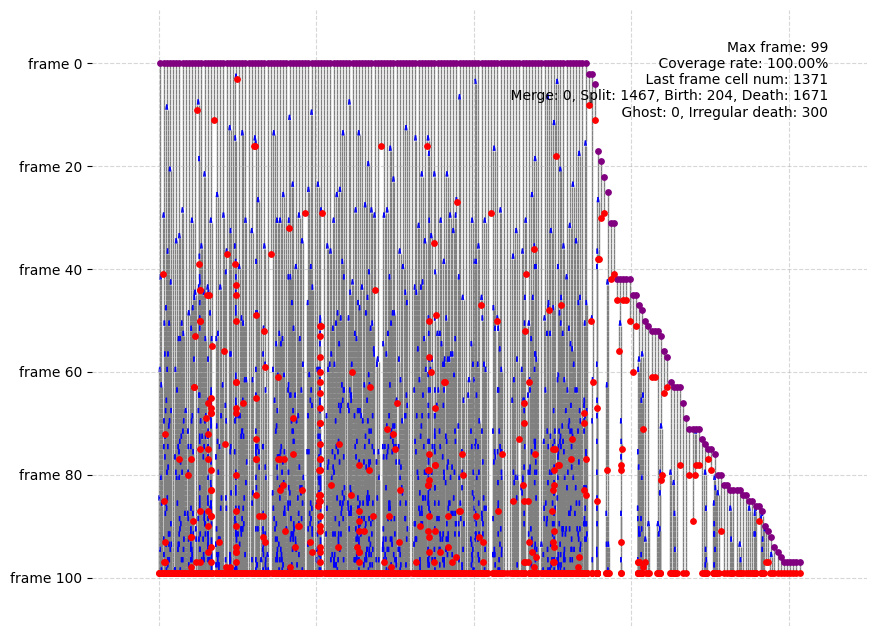

In [17]:
from superseggertoolkit import visualizer
visualizer.quick_lineage(G)

get into branch
do normalized


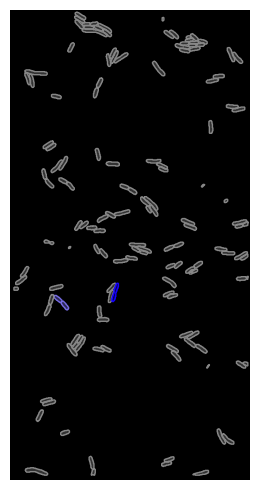

In [18]:
from superseggertoolkit import visualizer
label_info = visualizer.get_label_info(G)
composer.show_frame_phase(G = G, frame = 10, label_style = "empty", figsize = (15, 5), info = label_info, save = False)